In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import mdshare
import pyemma
import argparse
import os
import glob
import deeptime
from deeptime.markov.msm import MaximumLikelihoodMSM
from deeptime.markov import pcca
from deeptime.markov import reactive_flux
from tqdm.notebook import tqdm
from deeptime.util.validation import implied_timescales
from deeptime.plots import plot_implied_timescales

In [2]:
E1 = 4.0
E2 = 4.5

def v(x, y):
    return 3.0*np.e**(-x**2 + -(y-1.0/3)**2) - E1*np.e**(-x**2-(y-5.0/3)**2)\
         - E2*np.e**(-(x-1.0)**2 + -y**2) - E2*np.e**(-(x+1.0)**2 + -y**2)\
         + 2.0/10.0 * (x**4 + (y-1.0/3)**4)         

def f(v):
    x = v[0]
    y = v[1]
    return 3.0*np.e**(-x**2 + -(y-1.0/3)**2) - E1*np.e**(-x**2-(y-5.0/3)**2)\
         - E2*np.e**(-(x-1.0)**2 + -y**2) - E2*np.e**(-(x+1.0)**2 + -y**2)\
         + 2.0/10.0 * (x**4 + (y-1.0/3)**4)    

def F(v):
    x = v[0]
    y = v[1]
    Vx = -3.0*2.0*x * np.e**(-x**2 + -(y-1.0/3)**2) + E1*2.0*x*np.e**(-x**2-(y-5.0/3)**2)\
        + E2 * 2.0 * ((x-1.0)*np.e**(-(x-1.0)**2 + -y**2) + (x+1.0)*np.e**(-(x+1.0)**2 + -y**2))\
        + 8.0/10 * x**3

    Vy = -3.0 * 2.0 * (y-1.0/3)*np.e**(-x**2-(y-1.0/3)**2) + E1 * 2.0 * (y-5.0/3)*np.e**(-x**2-(y-5.0/3)**2)\
        + E2*2.0*y * (np.e**(-(x-1.0)**2 + -y**2) + np.e**(-(x+1.0)**2 + -y**2))\
        + 8.0/10 * (y-1.0/3)**3

    return np.array([Vx, Vy])                  

def euler_propagation(v0, N, dt, beta):
    dim = v0.shape[0]
    sigma  = np.sqrt(2.0*dt/beta)
    dW = np.random.randn(N, dim)
    v = np.zeros((N, dim))
    v[0, :] = v0
    for i in range(N-1):
        v[i+1, :] = v[i, :] + -F(v[i, :])*dt + sigma * dW[i, :]
    return v       
def generate(N,beta,outfile):
    dt = 1e-3
    S0 = np.array([-1.0, 0.0])
    S = euler_propagation(S0, N, dt, beta)
    if os.path.splitext(outfile)[1]=='.npy':
        np.save(outfile, S)

    nx = 100
    lx = -1.8
    Lx = 1.8
    x = np.linspace(lx, Lx, nx)
    ly = -1.2
    Ly = 2.2
    y = np.linspace(ly, Ly, nx)
    X, Y = np.meshgrid(x, y)
    Z = v(X, Y)
    levels = np.array([-3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0])
    fig = plt.figure(0)
    ax = fig.add_subplot(111)
    ax.set_xlim(lx, Lx)
    ax.set_ylim(ly, Ly)
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")
    cs = ax.contour(X, Y, Z, levels)
    ax.plot(S[:, 0], S[:, 1], c='k')
    plt.clabel(cs, inline=1, fontsize=10)
    plt.show()
    return S

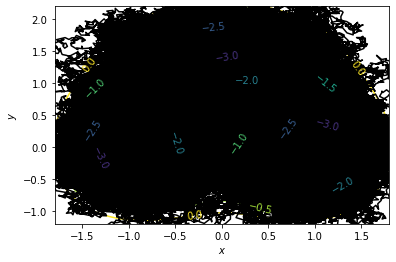

In [364]:
data=generate(1000000,1.5,'noidea.npy')

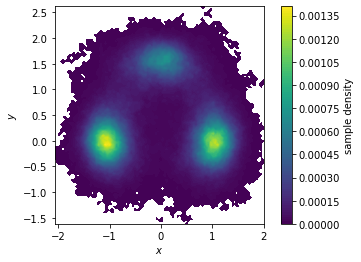

In [365]:
_, ax, _ = pyemma.plots.plot_density(
        *data.T)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal')

In [366]:
cluster = deeptime.clustering.BoxDiscretization(dim=2,n_boxes=50, v0=[-1.8,-1.2], v1=[1.8,2.2]).fit_fetch(data)

In [367]:
dtraj = cluster.transform(data)

In [368]:
nstates=3

In [302]:
models = []
for lag in tqdm([100, 200, 500, 1000, 2000, 4000], leave=False):
    counts_estimator = deeptime.markov.TransitionCountEstimator(lag, "sliding")
    counts = counts_estimator.fit_fetch(dtraj)
    counts = counts.submodel_largest()
    
    msm_estimator = MaximumLikelihoodMSM(lagtime=lag)
    models.append(msm_estimator.fit_fetch(counts))

  0%|          | 0/6 [00:00<?, ?it/s]

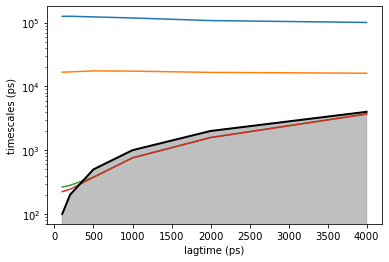

In [303]:
its = implied_timescales(models)
ax = plot_implied_timescales(its, n_its=4)
ax.set_yscale('log')
ax.set_xlabel('lagtime (ps)')
ax.set_ylabel('timescales (ps)');

In [369]:
counts = deeptime.markov.TransitionCountEstimator(500, 'sliding').fit(dtraj).fetch_model().submodel_largest()
msm = MaximumLikelihoodMSM(lagtime=500).fit_fetch(counts)

In [370]:
pcca = msm.pcca(nstates)

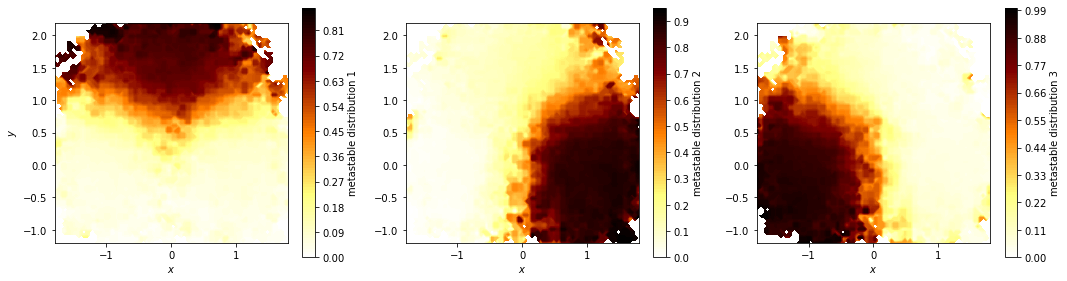

In [371]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *data.T, pcca.memberships.T[i][counts.transform_discrete_trajectories_to_submodel(dtraj)], ax=ax, cmap='afmhot_r', 
        mask=True, method='nearest', cbar_label='metastable distribution {}'.format(i + 1))
    #ax.scatter(*cluster.cluster_centers.T, s=15, c='k')
    ax.set_xlabel('$x$')
    ax.set_xlim(-1.8, 1.8)
    ax.set_ylim(-1.2, 2.2)
    ax.set_aspect('equal')
axes[0].set_ylabel('$y$')
fig.tight_layout()

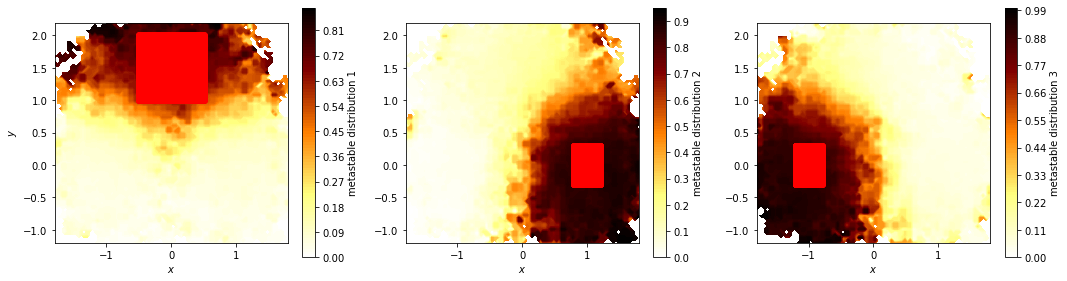

In [383]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
grids = [gridC, gridB, gridA]
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *data.T, pcca.memberships.T[i][counts.transform_discrete_trajectories_to_submodel(dtraj)], ax=ax, cmap='afmhot_r', 
        mask=True, method='nearest', cbar_label='metastable distribution {}'.format(i + 1))
    ax.scatter(*grids[i].T, c='red')
    ax.set_xlabel('$x$')
    ax.set_xlim(-1.8, 1.8)
    ax.set_ylim(-1.2, 2.2)
    ax.set_aspect('equal')
axes[0].set_ylabel('$y$')
fig.tight_layout()

In [372]:
gridA = np.dstack(np.meshgrid(np.linspace(-1.2,-0.8, 100), np.linspace(-0.3,0.3, 100))).reshape(-1, 2)
A2 = np.unique(cluster.transform(gridA))

In [373]:
gridB = np.dstack(np.meshgrid(np.linspace(0.8,1.2, 100), np.linspace(-0.3,0.3, 100))).reshape(-1, 2)
B2 = np.unique(cluster.transform(gridB))

In [374]:
gridC = np.dstack(np.meshgrid(np.linspace(-0.5,0.5, 100), np.linspace(1.0,2.0, 100))).reshape(-1, 2)
C2 = np.unique(cluster.transform(gridC))

In [375]:
flux = msm.reactive_flux(A2, B2)
cg, cgflux = flux.coarse_grain([A2, B2, C2])
coarse_state_centers = np.array( [
np.mean(cluster.cluster_centers[list(cg[0])], axis=0),
np.mean(cluster.cluster_centers[list(cg[1])], axis=0),
np.mean(cluster.cluster_centers[list(cg[2])], axis=0),
np.mean(cluster.cluster_centers[list(cg[3])], axis=0)])

In [324]:
A_fail = pcca.sets[1].astype(np.int32) #set 2 contains x1
B_fail = pcca.sets[2].astype(np.int32) #set 3 contains x2
flux_fail = msm.reactive_flux(A_fail, B_fail)
cg_fail, cgflux_fail = flux_fail.coarse_grain(pcca.sets)
highest_membership = pcca.metastable_distributions.argmax(1)
coarse_state_centers_fail = cluster.cluster_centers[msm.count_model.state_symbols[highest_membership]]

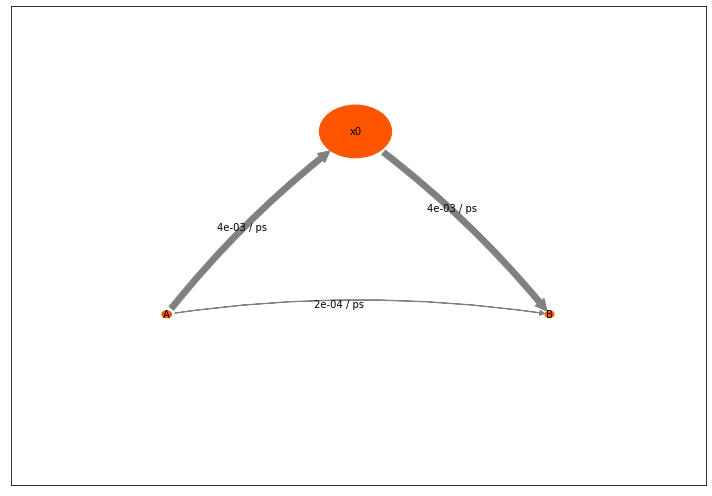

In [351]:
fig, ax = plt.subplots(figsize=(10, 7))
pyemma.plots.plot_flux(
    cgflux,
    coarse_state_centers,
    cgflux.stationary_distribution,
    state_labels=['A' ,'x0', 'B'], 
    ax=ax,
    show_committor=False,
    figpadding=0,
    show_frame=True,
    arrow_label_format='%2.e / ps');
ax.set_xlim(-1.8, 1.8)
ax.set_ylim(-1.2, 2.2)
fig.tight_layout()

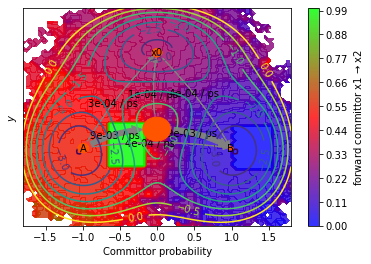

In [378]:
nx = 100
lx = -1.8
Lx = 1.8
x = np.linspace(lx, Lx, nx)
ly = -1.2
Ly = 2.2
y = np.linspace(ly, Ly, nx)
X, Y = np.meshgrid(x, y)
Z = v(X, Y)
levels = np.array([-3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0])
fig = plt.figure(0)
ax = fig.add_subplot(111)
ax.set_xlim(lx, Lx)
ax.set_ylim(ly, Ly)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
cs = ax.contour(X, Y, Z, levels)

pyemma.plots.plot_contour(
    *data.T,
    flux.forward_committor[counts.transform_discrete_trajectories_to_submodel(dtraj)],
    cmap='brg',
    ax=ax,
    mask=True,
    cbar_label=r'forward committor x1 $\to$ x2',
    alpha=0.8,
    zorder=-1)

pyemma.plots.plot_flux(
    cgflux,
    coarse_state_centers,
    cgflux.stationary_distribution,
    state_labels=['A' ,'x0', '', 'B'], 
    ax=ax,
    show_committor=True,
    figpadding=0,
    show_frame=True,
    arrow_label_format='%2.e / ps');
ax.set_xlim(-1.8, 1.8)
ax.set_ylim(-1.2, 2.2)

plt.clabel(cs, inline=1, fontsize=10)
plt.show()

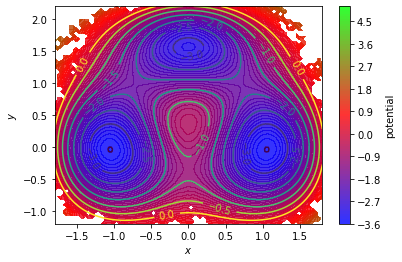

In [379]:
nx = 100
lx = -1.8
Lx = 1.8
x = np.linspace(lx, Lx, nx)
ly = -1.2
Ly = 2.2
y = np.linspace(ly, Ly, nx)
X, Y = np.meshgrid(x, y)
Z = v(X, Y)
levels = np.array([-3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0])
fig = plt.figure(0)
ax = fig.add_subplot(111)
ax.set_xlim(lx, Lx)
ax.set_ylim(ly, Ly)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
cs = ax.contour(X, Y, Z, levels)

pyemma.plots.plot_contour(
    *data.T,
    f(data.T),
    cmap='brg',
    ax=ax,
    mask=True,
    cbar_label=r'potential',
    #levels=np.array([-3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0]),
    alpha=0.8,
    zorder=-1)

plt.clabel(cs, inline=1, fontsize=10)
plt.show()

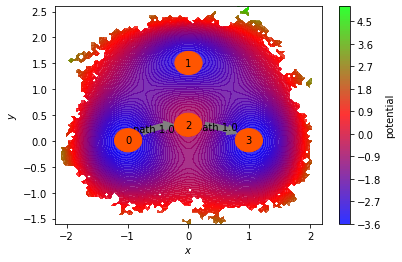

In [382]:
levels = np.array([-3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0])
fig = plt.figure(10)
ax = fig.add_subplot(111)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
pyemma.plots.plot_contour(*data.T, f(data.T), cmap='brg', ax=ax, mask=True,
    cbar_label=r'potential', alpha=0.8, zorder=-1)


#metastates, metastates, (path number, weight)
weights = np.zeros((4,4, 2))
for i in range(len(paths)):
    for j in range(len(paths[i])):
        if j + 1 < len(paths[i]):
            weights[paths[i][j], paths[i][j+1]] = [i + 1, path_fluxes[i]]
pyemma.plots.plot_network(weights[:,:,1], coarse_state_centers, arrow_labels=np.vectorize(lambda x: 'path {}'.format(x))(weights[:, :, 0]), ax=ax, xticks=True, yticks=True, show_frame=True )
ax.set_xlim(-2.2,2.2)
ax.set_ylim(-1.6,2.6)
plt.show()